In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import math

In [3]:
import torch
from torchvision import transforms, datasets

train_data_transform = transforms.Compose([
        
#         transforms.Lambda(lbp_transform),
#         transforms.Lambda(combine_lbp_hog),
#         transforms.ToPILImage(),
        # transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=20),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

test_data_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/Training', transform=train_data_transform)
val_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/PublicTest', transform=test_data_transform)
test_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/PrivateTest/', transform=test_data_transform)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_features, out_features, num_conv, pool=False):
        super(ConvBlock, self).__init__()
        features = [in_features] + [out_features for i in range(num_conv)]
        layers = []
        for i in range(len(features)-1):
            layers.append(nn.Conv2d(in_channels=features[i], out_channels=features[i+1], kernel_size=3, padding=1, bias=True))
            layers.append(nn.BatchNorm2d(num_features=features[i+1], affine=True, track_running_stats=True))
            layers.append(nn.ReLU())
            if pool:
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        self.op = nn.Sequential(*layers)
    def forward(self, x):
        return self.op(x)

class ProjectorBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ProjectorBlock, self).__init__()
        self.op = nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=1, padding=0, bias=False)
    def forward(self, inputs):
        return self.op(inputs)

class LinearAttentionBlock(nn.Module):
    def __init__(self, in_features, normalize_attn=True):
        super(LinearAttentionBlock, self).__init__()
        self.normalize_attn = normalize_attn
        self.op = nn.Conv2d(in_channels=in_features, out_channels=1, kernel_size=1, padding=0, bias=False)
    def forward(self, l, g):
        N, C, W, H = l.size()
        c = self.op(l+g) # batch_sizex1xWxH
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)
        g = torch.mul(a.expand_as(l), l)
        if self.normalize_attn:
            g = g.view(N,C,-1).sum(dim=2) # batch_sizexC
        else:
            g = F.adaptive_avg_pool2d(g, (1,1)).view(N,C)
        return c.view(N,1,W,H), g

In [5]:
import torch.nn as nn
import numpy as np

def weights_init_kaimingUniform(module):
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.uniform_(m.weight, a=0, b=1)
            nn.init.constant_(m.bias, val=0.)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, val=0.)

def weights_init_kaimingNormal(module):
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, val=0.)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, val=0.)

def weights_init_xavierUniform(module):
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=np.sqrt(2))
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.uniform_(m.weight, a=0, b=1)
            nn.init.constant_(m.bias, val=0.)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=np.sqrt(2))
            if m.bias is not None:
                nn.init.constant_(m.bias, val=0.)

def weights_init_xavierNormal(module):
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight, gain=np.sqrt(2))
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, val=0.)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight, gain=np.sqrt(2))
            if m.bias is not None:
                nn.init.constant_(m.bias, val=0.)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from blocks import ConvBlock, LinearAttentionBlock, ProjectorBlock
# from initialize import *

'''
attention after max-pooling
'''

class AttnVGG_after(nn.Module):
    def __init__(self, im_size, num_classes, attention=True, normalize_attn=True, init='xavierUniform'):
        super(AttnVGG_after, self).__init__()
        self.attention = attention
        # conv blocks
        self.conv_block1 = ConvBlock(1, 64, 2)
        self.conv_block2 = ConvBlock(64, 128, 2)
        self.conv_block3 = ConvBlock(128, 256, 3)
        self.conv_block4 = ConvBlock(256, 512, 3)
        self.conv_block5 = ConvBlock(512, 512, 3)
        self.conv_block6 = ConvBlock(512, 512, 2, pool=True)
        self.dense = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=int(im_size/32), padding=0, bias=True)
        # Projectors & Compatibility functions
        if self.attention:
            self.projector = ProjectorBlock(256, 512)
            self.attn1 = LinearAttentionBlock(in_features=512, normalize_attn=normalize_attn)
            self.attn2 = LinearAttentionBlock(in_features=512, normalize_attn=normalize_attn)
            self.attn3 = LinearAttentionBlock(in_features=512, normalize_attn=normalize_attn)
        # final classification layer
        if self.attention:
            self.classify = nn.Linear(in_features=512*3, out_features=num_classes, bias=True)
        else:
            self.classify = nn.Linear(in_features=512, out_features=num_classes, bias=True)
        # initialize
        if init == 'kaimingNormal':
            weights_init_kaimingNormal(self)
        elif init == 'kaimingUniform':
            weights_init_kaimingUniform(self)
        elif init == 'xavierNormal':
            weights_init_xavierNormal(self)
        elif init == 'xavierUniform':
            weights_init_xavierUniform(self)
        else:
            raise NotImplementedError("Invalid type of initialization!")
    def forward(self, x):
        # feed forward
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        l1 = F.max_pool2d(x, kernel_size=2, stride=2, padding=0) # /2
        l2 = F.max_pool2d(self.conv_block4(l1), kernel_size=2, stride=2, padding=0) # /4
        l3 = F.max_pool2d(self.conv_block5(l2), kernel_size=2, stride=2, padding=0) # /8
        x = self.conv_block6(l3) # /32
        g = self.dense(x) # batch_sizex512x1x1
        # pay attention
        if self.attention:
            c1, g1 = self.attn1(self.projector(l1), g)
            c2, g2 = self.attn2(l2, g)
            c3, g3 = self.attn3(l3, g)
            g = torch.cat((g1,g2,g3), dim=1) # batch_sizexC
            # classification layer
            x = self.classify(g) # batch_sizexnum_classes
        else:
            c1, c2, c3 = None, None, None
            x = self.classify(torch.squeeze(g))
#         return [x, c1, c2, c3]
        return x

In [7]:
from torch.optim import lr_scheduler

device = torch.device('cuda')
print(device)

model = AttnVGG_after(48, 7)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
# reduce_factor = 2
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [8]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/learn_to_pay_att/'
model_name = 'model_after'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(100):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  1
- Avg.loss: 1.798  | Avg.acc: 0.251
- Avg. val_loss: 1.755  | Avg. val_acc: 0.276
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AttnVGG_after. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ProjectorBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type LinearAttentionBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


- Avg.loss: 1.740  | Avg.acc: 0.283
- Avg. val_loss: 1.750  | Avg. val_acc: 0.242
Epoch:  3
- Avg.loss: 1.703  | Avg.acc: 0.300
- Avg. val_loss: 1.757  | Avg. val_acc: 0.283
* Update optimal model
Epoch:  4
- Avg.loss: 1.643  | Avg.acc: 0.340
- Avg. val_loss: 1.584  | Avg. val_acc: 0.397
* Update optimal model
Epoch:  5
- Avg.loss: 1.525  | Avg.acc: 0.400
- Avg. val_loss: 1.512  | Avg. val_acc: 0.405
* Update optimal model
Epoch:  6
- Avg.loss: 1.447  | Avg.acc: 0.441
- Avg. val_loss: 1.382  | Avg. val_acc: 0.467
* Update optimal model
Epoch:  7
- Avg.loss: 1.394  | Avg.acc: 0.457
- Avg. val_loss: 1.376  | Avg. val_acc: 0.475
* Update optimal model
Epoch:  8
- Avg.loss: 1.360  | Avg.acc: 0.474
- Avg. val_loss: 1.445  | Avg. val_acc: 0.430
Epoch:  9
- Avg.loss: 1.332  | Avg.acc: 0.485
- Avg. val_loss: 1.295  | Avg. val_acc: 0.494
* Update optimal model
Epoch:  10
- Avg.loss: 1.316  | Avg.acc: 0.493
- Avg. val_loss: 1.308  | Avg. val_acc: 0.493
Epoch:  11
- Avg.loss: 1.303  | Avg.acc: 0.

- Avg.loss: 1.015  | Avg.acc: 0.616
- Avg. val_loss: 1.066  | Avg. val_acc: 0.607
Epoch:  84
- Avg.loss: 1.020  | Avg.acc: 0.615
- Avg. val_loss: 1.049  | Avg. val_acc: 0.606
Epoch:  85
- Avg.loss: 1.019  | Avg.acc: 0.612
- Avg. val_loss: 1.081  | Avg. val_acc: 0.595
Epoch:  86
- Avg.loss: 1.016  | Avg.acc: 0.613
- Avg. val_loss: 1.070  | Avg. val_acc: 0.605
Epoch:  87
- Avg.loss: 1.016  | Avg.acc: 0.615
- Avg. val_loss: 1.054  | Avg. val_acc: 0.608
Epoch:  88
- Avg.loss: 1.012  | Avg.acc: 0.616
- Avg. val_loss: 1.068  | Avg. val_acc: 0.603
Epoch:  89
- Avg.loss: 1.014  | Avg.acc: 0.613
- Avg. val_loss: 1.076  | Avg. val_acc: 0.596
Epoch:  90
- Avg.loss: 1.015  | Avg.acc: 0.613
- Avg. val_loss: 1.066  | Avg. val_acc: 0.595
Epoch:  91
- Avg.loss: 1.012  | Avg.acc: 0.618
- Avg. val_loss: 1.061  | Avg. val_acc: 0.598
Epoch:  92
- Avg.loss: 1.017  | Avg.acc: 0.612
- Avg. val_loss: 1.080  | Avg. val_acc: 0.600
Epoch:  93
- Avg.loss: 1.011  | Avg.acc: 0.614
- Avg. val_loss: 1.056  | Avg. val

([<matplotlib.lines.Line2D at 0x7f0a812ebef0>,
 0.6144911504424779,
 1.0553976334301771)

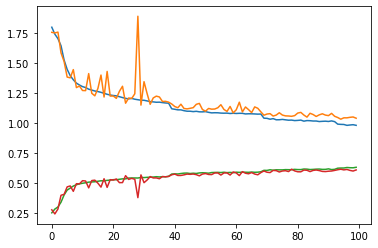

In [10]:
plt.plot(hist), best_acc, curloss